In [1]:
from google.colab import files
import os
def import_the_dataset_kaggle(api_command):
  !pip install -q kaggle
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  os.system(api_command)
  ! mkdir train
  os.system("unzip best-artworks-of-all-time.zip -d train/")
  os.system("rm best-artworks-of-all-time.zip")

import_the_dataset_kaggle('kaggle datasets download -d ikarus777/best-artworks-of-all-time')

Saving kaggle.json to kaggle.json


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

print(tf.__version__)

2.3.0


In [3]:
TRAIN_DIR = '/content/train/images/images'

In [4]:
artists_df = pd.read_csv('/content/train/artists.csv')
artists_df.drop(['id', 'bio', 'wikipedia'], axis=1, inplace=True)
artists_df.head()

,name,years,genre,nationality,paintings
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,193
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,88
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,70
3,Claude Monet,1840 - 1926,Impressionism,French,73
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,194


In [5]:
artists_df = artists_df.sort_values(by=['paintings'], ascending=False)
artists_top = artists_df[artists_df['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [6]:
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [7]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [8]:
artists_top_name = artists_top['name'].str.replace(' ', '_')

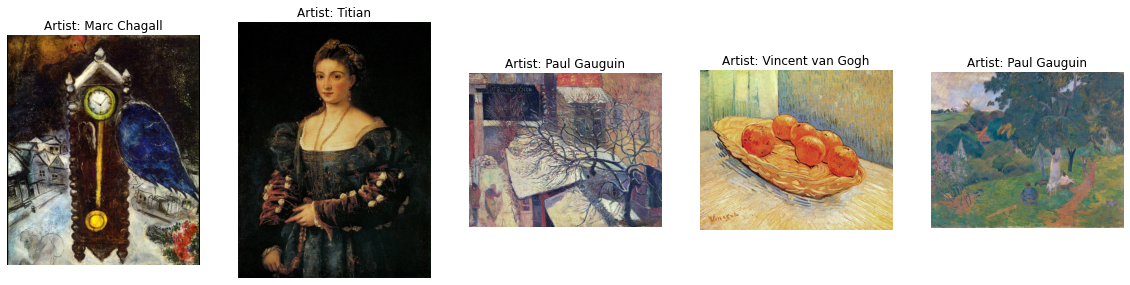

In [9]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(TRAIN_DIR, random_artist)))
    random_image_file = os.path.join(TRAIN_DIR, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [10]:
batch_size = 32
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
print(f"Total number of Train Batches: {STEP_SIZE_TRAIN}, Validation Batches: {STEP_SIZE_VALID}")

Found 3181 images belonging to 11 classes.
Found 790 images belonging to 11 classes.
Total number of Train Batches: 99, Validation Batches: 24


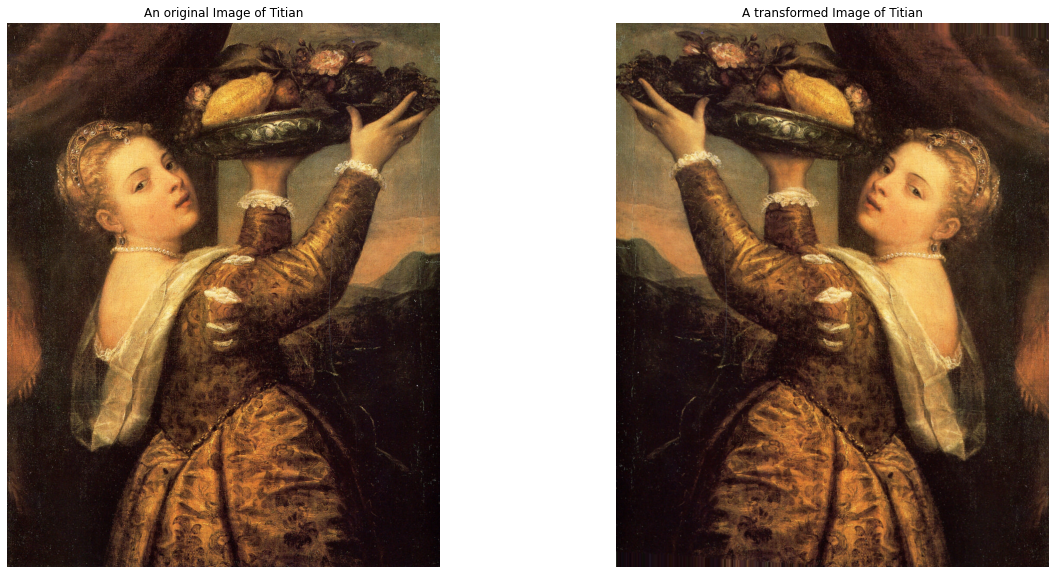

In [11]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(TRAIN_DIR, random_artist)))
random_image_file = os.path.join(TRAIN_DIR, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [17]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
# X = Dropout(0.5)(X) 
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
# X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [18]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [19]:
n_epoch = 10
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [20]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              class_weight=class_weights
                             )

Epoch 1/10
99/99 [==============================] - 107s 1s/step - loss: 1.1148 - accuracy: 0.6310 - val_loss: 2.5521 - val_accuracy: 0.1367
Epoch 2/10
99/99 [==============================] - 106s 1s/step - loss: 0.9343 - accuracy: 0.7117 - val_loss: 2.1750 - val_accuracy: 0.2370
Epoch 3/10
99/99 [==============================] - 106s 1s/step - loss: 0.8507 - accuracy: 0.7628 - val_loss: 2.0668 - val_accuracy: 0.3685
Epoch 4/10
99/99 [==============================] - 106s 1s/step - loss: 0.7792 - accuracy: 0.8514 - val_loss: 2.0277 - val_accuracy: 0.3867
Epoch 5/10
99/99 [==============================] - 106s 1s/step - loss: 0.7323 - accuracy: 0.8854 - val_loss: 1.5841 - val_accuracy: 0.6120
Epoch 6/10
99/99 [==============================] - 106s 1s/step - loss: 0.6702 - accuracy: 0.9178 - val_loss: 1.1939 - val_accuracy: 0.7708
Epoch 7/10
99/99 [==============================] - 106s 1s/step - loss: 0.6103 - accuracy: 0.9336 - val_loss: 1.0960 - val_accuracy: 0.8047
Epoch 8/10
99

In [21]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              class_weight=class_weights
                             )

Epoch 1/50
99/99 [==============================] - 106s 1s/step - loss: 0.3948 - accuracy: 0.9736 - val_loss: 0.9720 - val_accuracy: 0.7799
Epoch 2/50
99/99 [==============================] - 104s 1s/step - loss: 0.3614 - accuracy: 0.9784 - val_loss: 0.9282 - val_accuracy: 0.7812
Epoch 3/50
99/99 [==============================] - 104s 1s/step - loss: 0.3452 - accuracy: 0.9806 - val_loss: 0.8879 - val_accuracy: 0.8229
Epoch 4/50
99/99 [==============================] - 104s 1s/step - loss: 0.3319 - accuracy: 0.9854 - val_loss: 0.8338 - val_accuracy: 0.8333
Epoch 5/50
99/99 [==============================] - 104s 1s/step - loss: 0.3240 - accuracy: 0.9854 - val_loss: 0.8209 - val_accuracy: 0.8359
Epoch 6/50
99/99 [==============================] - 103s 1s/step - loss: 0.3078 - accuracy: 0.9841 - val_loss: 0.8458 - val_accuracy: 0.8112
Epoch 7/50
99/99 [==============================] - 104s 1s/step - loss: 0.2990 - accuracy: 0.9873 - val_loss: 0.8400 - val_accuracy: 0.8255
Epoch 8/50
99

In [25]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

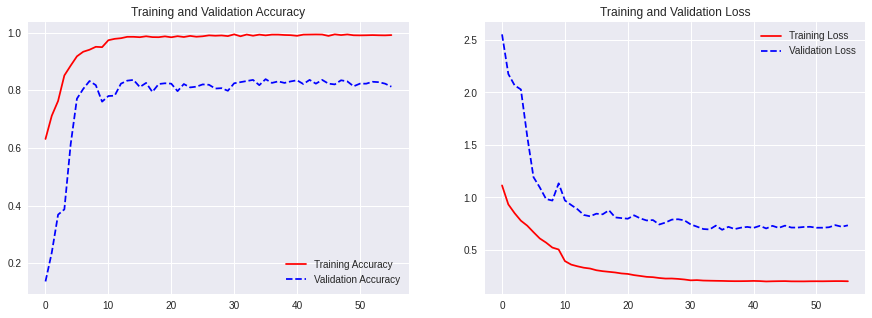

In [58]:
plt.style.use('seaborn')
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    plt.savefig('plots.png')
    plt.show()
    
plot_training(history)

In [27]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
100/100 [==============================] - 78s 777ms/step - loss: 0.2787 - accuracy: 0.9943
Prediction accuracy on train data = 0.9943413734436035


In [28]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

25/25 [==============================] - 19s 742ms/step - loss: 0.7350 - accuracy: 0.8278
Prediction accuracy on CV data = 0.8278480768203735


In [29]:
# get predictions 
def get_predictions_and_labels(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)

    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    return y_pred, y_true

In [30]:
p_valid, y_valid = get_predictions_and_labels(model, valid_generator, STEP_SIZE_VALID)

In [33]:
p_valid.shape

(768,)

In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(p_valid, y_valid)

In [43]:
artists_top_name.iloc[0]

'Vincent_van_Gogh'

In [63]:
import pandas as pd
import seaborn as sn
def plot_confusion_matrix(cm):
  df_cm = pd.DataFrame(
      cm,  
      index=[artists_top_name.iloc[i].replace('_', ' ') for i in range(artists_top_name.shape[0] - 1)], 
      columns=[artists_top_name.iloc[i].replace('_', ' ') for i in range(artists_top_name.shape[0] - 1)]
  )
  plt.figure(figsize=(15, 10))
  sns_plot = sn.heatmap(df_cm, annot=False)
  fig = sns_plot.get_figure()
  fig.savefig('confusionMatrix.png') 

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 776 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 776 missing from current font.
  font.set_text(s, 0, flags=flags)


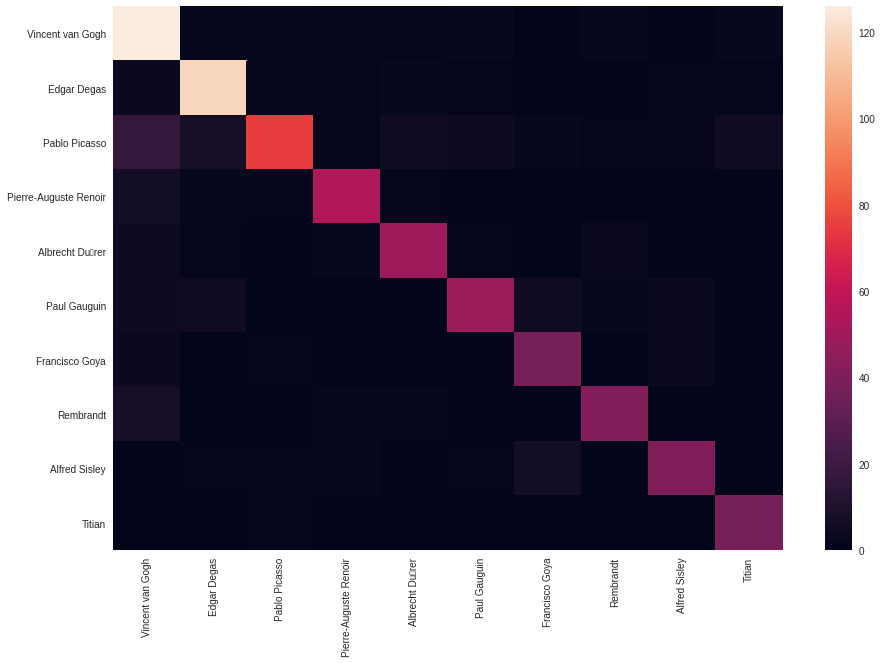

In [64]:
plot_confusion_matrix(cm)

Predicted artist: Vincent van Gogh
Prediction score: 53.05109620094299%


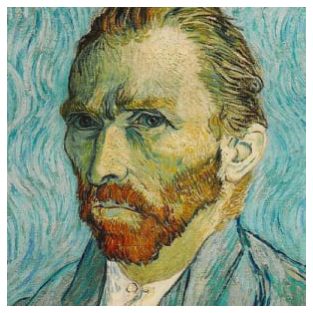

In [76]:
# put any url of the artwork to know the artist!
url = 'https://www.biography.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cg_face%2Cq_auto:good%2Cw_300/MTY2NTIzMzc4MTI2MDM4MjM5/vincent_van_gogh_self_portrait_painting_musee_dorsay_via_wikimedia_commons_promojpg.jpg'

import imageio
import cv2

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print(f"Predicted artist: {artists_top_name.iloc[prediction_idx].replace('_', ' ')}")
print(f"Prediction score: {prediction_probability * 100}%", )

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show();